In [20]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

In [2]:
# Load dataset
data = pd.read_csv('data/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [3]:
# Preview data
print(data.head())

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

In [4]:
# Convert TotalCharges to numeric and handle missing
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
data.dropna(inplace=True)

In [5]:
# Encode categorical variables
for col in data.select_dtypes(include='object').columns:
    if col != 'customerID':
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col])

In [6]:
# Prepare features and target
X = data.drop(['customerID', 'Churn'], axis=1)
y = data['Churn']

In [7]:
# Split data into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [21]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost Model': XGBClassifier()
}

results = []

# Train & Evaluate
for name, model in models.items():
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    train_acc = accuracy_score(y_train, train_pred)
    test_acc = accuracy_score(y_test, test_pred)
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    cv_mean = cv_scores.mean()

    print(f"\n====== {name} ======")
    print("Train accuracy:",train_acc)
    print("Test accuracy:",test_acc)
    print("Cross Validation Score:",cv_mean)
    print("Confusion Matrix:\n", confusion_matrix(y_test, test_pred))
    print("Classification Report:\n", classification_report(y_test, test_pred))

    results.append({
        'Model': name,
        'Train Accuracy': train_acc,
        'Test Accuracy': test_acc,
        'CV Score': cv_mean
    })


====== Logistic Regression ======
Train accuracy: 0.8067555555555556
Test accuracy: 0.7853589196872779
Cross Validation Score: 0.8053333333333335
Confusion Matrix:
 [[920 113]
 [189 185]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.89      0.86      1033
           1       0.62      0.49      0.55       374

    accuracy                           0.79      1407
   macro avg       0.73      0.69      0.70      1407
weighted avg       0.77      0.79      0.78      1407


====== Random Forest ======
Train accuracy: 0.9976888888888888
Test accuracy: 0.7903340440653873
Cross Validation Score: 0.7982222222222222
Confusion Matrix:
 [[932 101]
 [194 180]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.90      0.86      1033
           1       0.64      0.48      0.55       374

    accuracy                           0.79      1407
   macro avg       0.73      0.69  

In [23]:
# Comparison Table
results_df = pd.DataFrame(results)
print("\n=== Summary of Results ===")
print(results_df.sort_values(by='Train Accuracy', ascending=False))


=== Summary of Results ===
                 Model  Train Accuracy  Test Accuracy  CV Score
1        Random Forest        0.997689       0.790334  0.798222
2        XGBoost Model        0.939200       0.764037  0.791467
0  Logistic Regression        0.806756       0.785359  0.805333


XGBoost ROC-AUC: 0.808


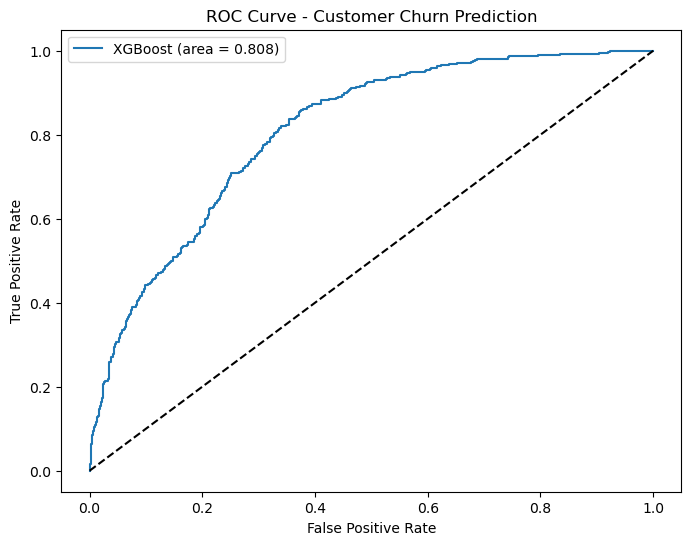

In [11]:
# ROC Curve for XGBoost
y_prob_xgb = xgb.predict_proba(X_test)[:,1]
roc_auc = roc_auc_score(y_test, y_prob_xgb)
print(f'XGBoost ROC-AUC: {roc_auc:.3f}')

fpr, tpr, _ = roc_curve(y_test, y_prob_xgb)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'XGBoost (area = {roc_auc:.3f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Customer Churn Prediction')
plt.legend()
plt.show()